<a href="https://colab.research.google.com/github/sohaib522/cat-vs-dog-classification-/blob/main/Cat_vs_dog_classification_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries that we will use later in the project

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
import pandas as pd
import zipfile
import cv2
from PIL import Image

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

Uploading kaggle.json to download our dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sohaibzq","key":"56da52f8a9d752080bbef7a46b1669c2"}'}

Installing kaggle library in Colab

In [ ]:
pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading required dataset

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 798M/812M [00:04<00:00, 220MB/s]
100% 812M/812M [00:04<00:00, 187MB/s]


We need to extract.zip file to get all the cat and dog images

In [ ]:
import zipfile
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall()

Now we extracted the .zip file these are files that we have got.

In [ ]:
import os
os.listdir(".")

['.config',
 'train.zip',
 'drive',
 'kaggle.json',
 'sampleSubmission.csv',
 'test1.zip',
 'dogs-vs-cats.zip',
 'sample_data']

Extracting train.zip to get all the images of dogs 🐕 and cats 🐈 on which we will train our model.

In [ ]:
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall()

Extracting test1.zip to get all the images of dogs and cat to check whether our model is performing well on unseen data.

In [ ]:
with zipfile.ZipFile('test1.zip', 'r') as zip_ref:
    zip_ref.extractall()

Checking the length of train images

In [ ]:
import os
path = 'train' # specify the path of the folder
num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
print(num_files)

Now we will separate out cat and dog images in different sub directoires.Our path for cat images will be like training_data/ cat for all cat images and training_data/dog for all dog images we doing this to label our images

In [ ]:
import os
import shutil

source_dir = "train"
cat_dir = "cat"
dog_dir = "dog"

# Create cat and dog directories if they don't exist

if not os.path.exists(cat_dir):
    os.makedirs(cat_dir)

if not os.path.exists(dog_dir):
    os.makedirs(dog_dir)

# Iterate through all files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith(".jpg"):
         #Checkif the image is a cat or dog image
        if "cat" in filename:
            destination_dir = cat_dir
        elif "dog" in filename:
            destination_dir = dog_dir
        else:
            continue

        # Copy the image to the corresponding directory
        source_path = os.path.join(source_dir, filename)
        destination_path = os.path.join(destination_dir, filename)
        shutil.copyfile(source_path, destination_path)

In [ ]:
import shutil
os.mkdir("training_data")
shutil.move('cat', 'training_data')
shutil.move('dog', 'training_data')

'training_data/dog'

Creating validation directory as main and cats & dog as sub directoires we creating validation dataset to check model's training on dataset

In [ ]:
os.makedirs("validation")
os.makedirs("validation/cat")
os.makedirs("validation/dog")

In [ ]:
import shutil

#shutil.rmtree("training_data")
#shutil.rmtree("validation")

In [ ]:
def validation_data(target_folder):
    count=0
    folder=os.path.join("training_data",target_folder)
    for image in os.listdir(folder):
      if count<2500 :
        source_path=os.path.join(folder,image)
        destination_path=os.path.join('validation',target_folder)
        shutil.move(source_path, destination_path)
        count=count+1

In [ ]:
validation_data("cat")
validation_data("dog")

In [ ]:
os.listdir("validation")

['dog', 'cat']

Its time to label our training & validation dataset. Keras library helps us in doing the task with labeling we are also resizing images to 224,224 that's the mandatory requirement of our neural network

In [ ]:
import tensorflow as tf

# specify the path of the train folder
train_dir = 'training_data'

# create a dataset from the train folder
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  labels='inferred', # infer the labels from the folder names
  label_mode='binary', # use binary labels (0 for cat, 1 for dog)
  image_size=(224, 224), # resize the images to 300x300
  batch_size=32 # use batches of 32 images
)
validation_dir='validation'
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  labels='inferred', # infer the labels from the folder names
  label_mode='binary', # use binary labels (0 for cat, 1 for dog)
  image_size=(224, 224), # resize the images to 300x300
  batch_size=32 # use batches of 32 images
)

# rescale the pixel values to [0, 1] range
#train_dataset = train_dataset.map(lambda x, y: (x / 255, y))*/

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


Lets us look at our training dataset look like after labeling

In [ ]:
def displaying_images_with_labels(images_folder):
    plt.figure(figsize=(10, 10))
    for images, labels in images_folder.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

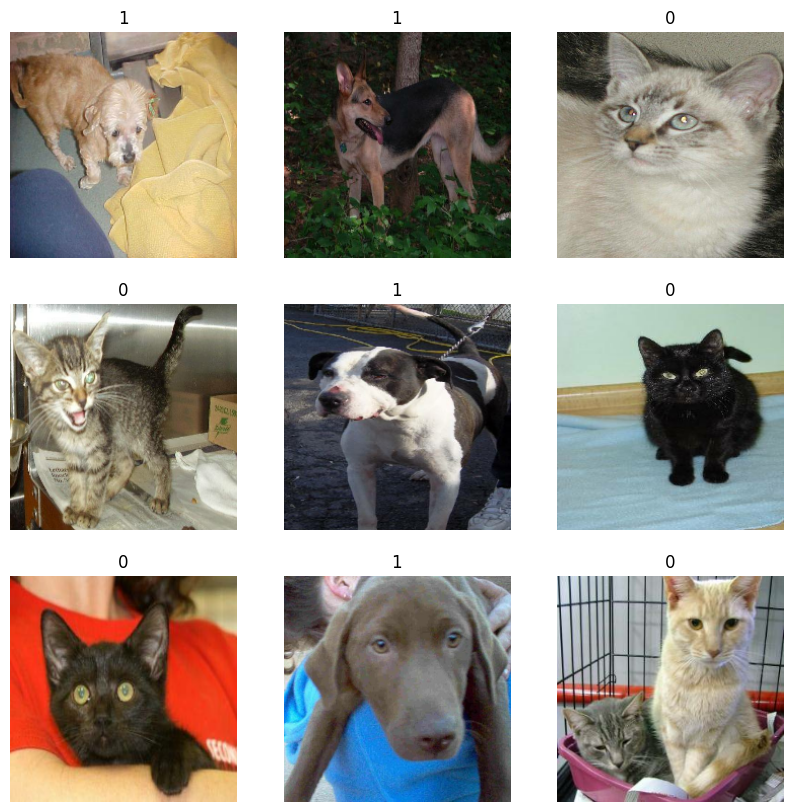

In [ ]:
displaying_images_with_labels(train_dataset)

We will repeat the same task for our validation dataset

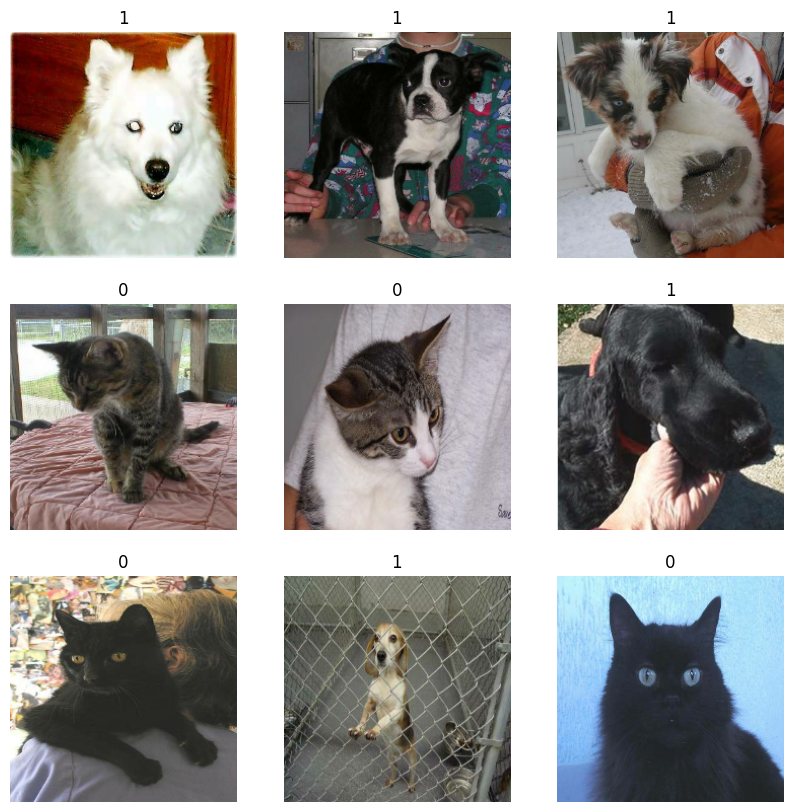

In [ ]:
displaying_images_with_labels(test_dataset)

Now we reducing our pixel values whaich are between 0 to 255 to  between 0 & 1.

In [ ]:
train_dataset.map(lambda x, y: (x / 255, y))

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
test_dataset.map(lambda x, y: (x / 255, y))

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Its time to introduce Resnet50 pre-trained model with 50 hidden layers and weights from imagenet.
We have weights and we don't want to learn weight during training so we freezing the weights that will also reduce our training time

In [ ]:

from tensorflow.compat.v1 import disable_eager_execution, enable_eager_execution

# Enable eager execution before building the model
#enable_eager_execution()
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


Training of model is about to begin. Please don't leave your seat its pre trained model and in only epoch it show accuracy of 0.97 significantly reducing the time to learn weights

In [ ]:

from tensorflow.keras.models import Sequential
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, steps_per_epoch=625, epochs=1, validation_data=test_dataset, validation_steps=len(train_dataset))
 #Evaluate the model
model.evaluate(test_dataset, steps=len(test_dataset))

625/625 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.9689

157/157 [==============================] - 15s 95ms/step - loss: 0.0593 - accuracy: 0.9790


[0.05934223532676697, 0.9789999723434448]

We will mount the drive to save our model in cloud that we can use later bypassing the process of training model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save("/content/drive/MyDrive/ML_models/dogvscat.keras")

Loading the model from drive

In [ ]:
from tensorflow.keras.models import load_model
path="/content/drive/MyDrive/ML_models/dogvscat.keras"
model=load_model(path)

Compiling the model

In [ ]:
from keras.models import load_model
from keras.preprocessing import image



# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
len(os.listdir("test1"))

12500

Image preprocessing module will convert the image into numpy array, resize images 224 224 3 so that we can feed into neural network

In [ ]:
def image_preprocessing(img):
    import cv2
    #img=cv2.imread(image)
    #img=cv2.resize(img,(224,224))
    img=np.array(img)
    #temp=img
    img=img.reshape(224,224,3)
    #img=img/255
    img = np.expand_dims (img, axis=0)
    return img
def model_predictions(img):
    prediction =model.predict(img)
    if prediction < 0.5:
       animal='cat'
       prediction=0
    else:
       animal='dog'
       prediction=1
    return animal, prediction

Lets check how our model is doing on unseen data ( images from test1 directory).

1/1 [==============================] - 0s 21ms/step


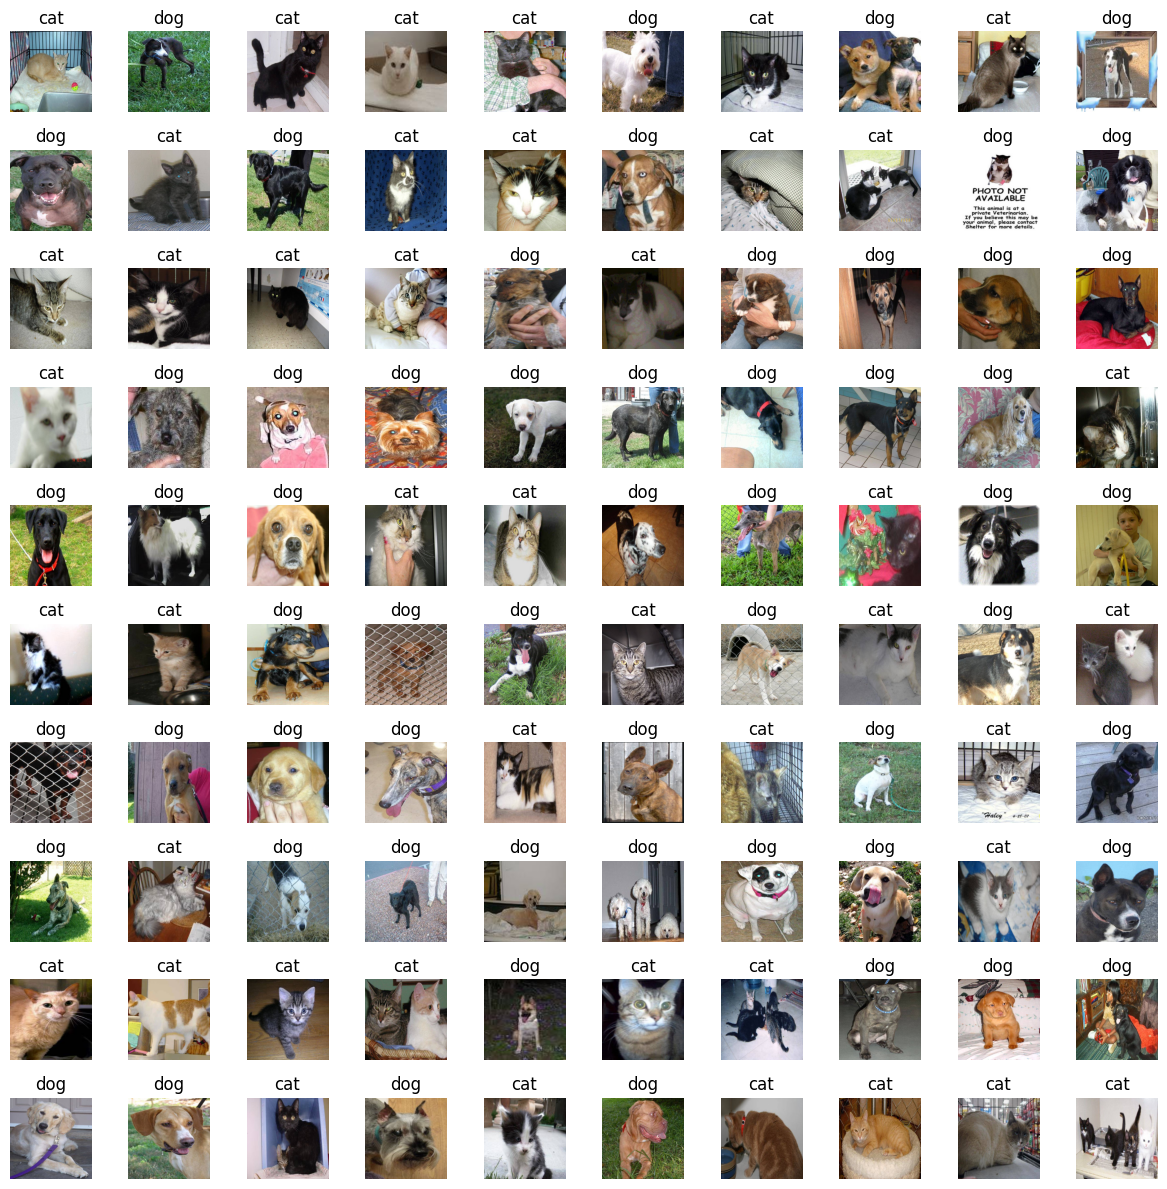

In [ ]:

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
# Get all image paths
image_paths = [os.path.join("test1", filename) for filename in os.listdir("test1")]

# Get 100 random paths
random_image_paths = random.sample(image_paths, 100)
# Figure size and number of rows and columns
rows = 10
cols = 10

# Create figure and set title
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Loop through random paths and display images
for i, image_path in enumerate(random_image_paths):
    # Read image
    image = Image.open(image_path)
    image = image.resize((224, 224), Image.LANCZOS)
    temp=image
    temp=image_preprocessing(temp)
    animal,_=model_predictions(temp)

    # Convert to RGB if needed
    if image.mode not in ("RGB", "RGBA"):
        image = image.convert("RGB")

    # Get row and column for subplot
    row_index = i // cols
    col_index = i % cols

    # Display image in subplot
    axes[row_index, col_index].imshow(image)
    axes[row_index, col_index].axis("off")
    axes[row_index, col_index].set_title(animal)

# Adjust layout and show plot
fig.tight_layout()
plt.show()

In [ ]:
import threading
predictions = []

In [ ]:


def predict_subset(images):
         for image in images:
             _, prediction = model_predictions(image)
             predictions.append(prediction)

In [ ]:
batch_size = 100
count=0
pre_process=[] # adjust this value as needed
for i in range(0, len(os.listdir("test1")), batch_size):
    image_batch = []
    for filename in os.listdir("test1")[i:i+batch_size]:
        image_batch.append(os.path.join("test1", filename))
        # process the image batch (explained below)
        #Preprocess all images in the batch

    processed_images = []
    for img in image_batch:
      image = Image.open(img)
      image = image.resize((224, 224), Image.LANCZOS)
      processed_images.append(image_preprocessing(image))

     # Define number of threads
    num_threads = 4


             # Store predictions and IDs (image indexes) somewhere

      # Divide processed images into subsets for threads
    images_subsets = np.array_split(processed_images, num_threads)

      # Create and start threads
    threads = []
    for subset in images_subsets:
       thread = threading.Thread(target=predict_subset, args=(subset,))
       thread.start()
       threads.append(thread)

# Wait for all threads to finish and collect results
    for thread in threads:
          thread.join()

# ... process and store collected predictions and IDs ...

# Clean up threads and resources

FileNotFoundError: ignored

In [ ]:
#len(predictions)
id=list(range(0,12467))
submission=pd.DataFrame({'id':id,'label': predictions})

In [ ]:
submission.to_csv("submissionfile.csv")

In [ ]:
submission.head()

id  label
0   0      1
1   1      0
2   2      1
3   3      0
4   4      1

In [ ]:
shutil.move("/content/drive/MyDrive/ML_models","submissionfile.csv")

FileExistsError: ignored

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Catvsdog"

/content/drive/MyDrive/Colab Notebooks/Catvsdog


In [ ]:
!git clone "https://github.com/sohaib522/cat-vs-dog-classification-.git"

Cloning into 'cat-vs-dog-classification-'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.
